In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import colorsys
import pandas as pd

In [2]:

hue_range = np.arange(0, 361, 1)
hue_fuzzy = ['WARM', 'COOL', 'WARM_']
hue = ctrl.Antecedent(hue_range, 'hue')
hue['WARM'] = fuzz.gaussmf(hue.universe, 0, 60)
hue['COOL'] = fuzz.gaussmf(hue.universe, 180, 60)
hue['WARM_'] = fuzz.gaussmf(hue.universe, 360, 60)


sat = ctrl.Antecedent(np.arange(0, 101, 1), 'saturation')
sat_fuzzy = ['GRAY', 'VERY_FADED', 'FADED', 'SATURATED', 'VERY_SATURATED']
sat['GRAY'] = fuzz.gaussmf(sat.universe, 0, 10)
sat['VERY_FADED'] = fuzz.gaussmf(sat.universe, 25, 10)
sat['FADED'] = fuzz.gaussmf(sat.universe, 50, 10)
sat['SATURATED'] = fuzz.gaussmf(sat.universe, 75, 10)
sat['VERY_SATURATED'] = fuzz.gaussmf(sat.universe, 100, 10)


val = ctrl.Antecedent(np.arange(0, 101, 1), 'value')
val_fuzzy = ['BLACK', 'VERY_DARK', 'DARK', 'BRIGHT', 'VERY_BRIGHT']
val['BLACK'] = fuzz.gaussmf(val.universe, 0, 10)
val['VERY_DARK'] = fuzz.gaussmf(val.universe, 25, 10)
val['DARK'] = fuzz.gaussmf(val.universe, 50, 10)
val['BRIGHT'] = fuzz.gaussmf(val.universe, 75, 10)
val['VERY_BRIGHT'] = fuzz.gaussmf(val.universe, 100, 10)

/Users/krishna/opt/anaconda3/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/krishna/opt/anaconda3/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/krishna/opt/anaconda3/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


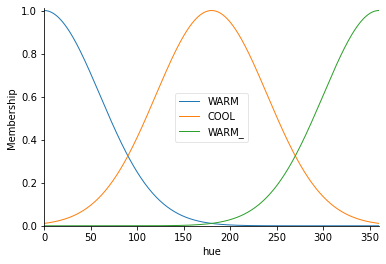

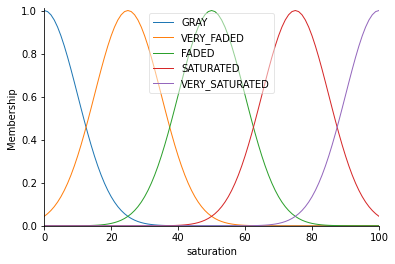

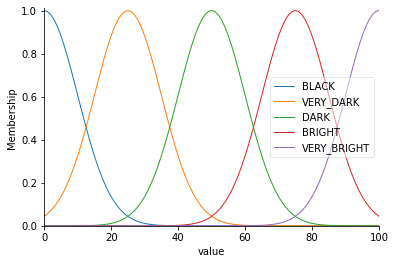

In [3]:
hue.view()
sat.view()
val.view()

In [4]:
tone_range = np.arange(0, 12, 1)
tone_fuzzy = ['NEUTRAL', 'DARK', 'BRIGHT']
tone = ctrl.Consequent(tone_range, 'tone')

tone['NEUTRAL'] = fuzz.trapmf(tone.universe, [0, 0, 1, 2])
tone['DARK'] = fuzz.gbellmf(tone.universe, 2, 1, 3)
tone['BRIGHT'] = fuzz.gbellmf(tone.universe, 4, 1, 9.5)

/Users/krishna/opt/anaconda3/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


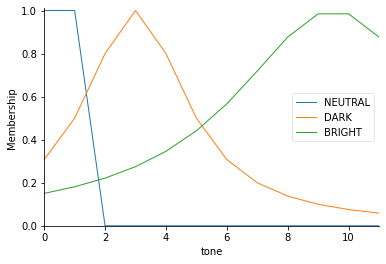

In [5]:
tone.view()


In [6]:
rule1 = ctrl.Rule(val['BLACK'] | sat['GRAY'] | sat['VERY_FADED'], tone['NEUTRAL'], 'Dark colors without color (low brightness/dark) considered neutral')
rule2 = ctrl.Rule(val['VERY_DARK'] & sat['SATURATED'], tone['NEUTRAL'], 'Very dark colors with high saturation')
rule3 = ctrl.Rule(val['DARK'] & sat['FADED'], tone['DARK'], 'Dark color with normal saturation')
rule4 = ctrl.Rule(val['DARK'] & sat['VERY_SATURATED'], tone['BRIGHT'], 'Dark color with high saturation')
rule5 = ctrl.Rule(val['BRIGHT'] & sat['SATURATED'], tone['BRIGHT'], 'Bright color with high saturation')
rule6 = ctrl.Rule(val['VERY_BRIGHT'] & sat['FADED'], tone['BRIGHT'], 'Very bright color with some saturation')
rule7 = ctrl.Rule(val['VERY_BRIGHT'] & sat['VERY_SATURATED'], tone['BRIGHT'], 'Very bright color with high saturation')
rule8 = ctrl.Rule(val['VERY_DARK'] & sat['FADED'], tone['NEUTRAL'], 'Very dark color with faded saturation')

In [7]:
tone_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])


In [8]:
tone_sim = ctrl.ControlSystemSimulation(tone_ctrl)

# test
tone_sim.input['saturation'] = 33
tone_sim.input['value'] = 97
tone_sim.compute()
tone_output = tone_sim.output['tone']
print(tone_output)

4.401875643979323


/Users/krishna/opt/anaconda3/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


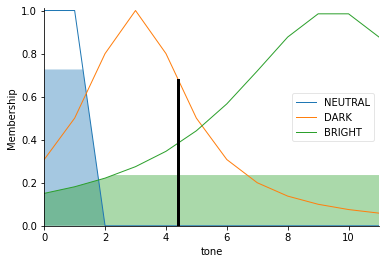

In [9]:
tone.view(sim=tone_sim)

In [10]:
def GetMembership(fuzzy_values, var_range, var_model, crisp_value):
    max_membership = 0
    membership_name = fuzzy_values[0]
    for i in range(len(fuzzy_values)):
        temp_memb = fuzz.interp_membership(var_range, var_model[fuzzy_values[i]].mf, crisp_value)
        if temp_memb > max_membership:
            max_membership = temp_memb
            membership_name = fuzzy_values[i]
    return membership_name

In [11]:
print(GetMembership(tone_fuzzy, tone_range, tone, tone_output))


DARK


In [12]:
def GetTone(values, verbose=False):
    tone_sim = ctrl.ControlSystemSimulation(tone_ctrl)
    tone_sim.input['saturation'] = values[0]
    tone_sim.input['value'] = values[1]
    tone_sim.compute()
    tone_output = tone_sim.output['tone']
    tone_membership= GetMembership(tone_fuzzy, tone_range, tone, tone_output)
    if verbose:
        print("TONE CRISP VALUE: ", tone_output)
        print("TONE FUZZY VALUE: ", tone_membership)
    return tone_membership

In [13]:
GetTone((96, 76), verbose=True)


TONE CRISP VALUE:  5.500000000000002
TONE FUZZY VALUE:  BRIGHT


'BRIGHT'

In [14]:
def GetColorTemp(hue_val, verbose=False):
    temp_membership = GetMembership(hue_fuzzy, hue_range, hue, hue_val)
    if verbose:
        print("TEMP. CRISP VALUE: ", hue_val)
        print("TEMP. FUZZY VALUE: ", temp_membership)
    return temp_membership

In [15]:
GetColorTemp(200, verbose=True)


TEMP. CRISP VALUE:  200
TEMP. FUZZY VALUE:  COOL


'COOL'

In [16]:
def GetColorDesc(hsv):
    tone = GetTone((hsv[1], hsv[2]))
    temp = GetColorTemp(hsv[0])
    if temp == "WARM_": temp = "WARM"
    return (tone, temp)

In [17]:
def ShowColor(hsv):
    rgb = colorsys.hsv_to_rgb(hsv[0]/360.0, hsv[1]/100.0, hsv[2]/100.0)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(3, 2)
    ax.set_facecolor(rgb)
    plt.tick_params(
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False)
    plt.title('HSV'+str(hsv))
    plt.show()

In [18]:
def ShowColorWithDesc(hsv):
    ShowColor(hsv)
    print(GetColorDesc(hsv))

In [19]:
def DisplayOutfitColors(outfit, valid_matches=[]):
    colors = [colorsys.hsv_to_rgb(hsv[0]/360.0, hsv[1]/100.0, hsv[2]/100.0) for hsv in outfit]

    plt.rcdefaults()
    fig, ax = plt.subplots()

    clothing = ('TOP', 'BOTTOM', 'SHOES')
    y_pos = np.arange(len(clothing))
    bar_width = [1, 1, 1]

    ax.barh(y_pos, bar_width, align='center', color=colors, height=0.99)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(clothing)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title('Outfit color scheme')
    ax.set_facecolor((0.8,0.8,0.8))

    plt.tick_params(
            left=True,
            bottom=False,
            labelleft=True,
            labelbottom=False)
    plt.margins(y=0, x=0)

    plt.show()
    
    print("Valid outfit color schemes: ", valid_matches)

In [20]:

universe_set =pd.DataFrame ([['BRIGHT','WARM'],['BRIGHT','COOL'],['NEUTRAL','WARM'],['NEUTRAL','COOL'],['DARK','WARM'],['DARK','COOL']], columns=['TONE','TEMP'])
print(universe_set)

      TONE  TEMP
0   BRIGHT  WARM
1   BRIGHT  COOL
2  NEUTRAL  WARM
3  NEUTRAL  COOL
4     DARK  WARM
5     DARK  COOL


In [21]:
"""
Basic outfit follow these rules
- No more than one bright color
- No high contrast between colors (bright warm + dark cool)
- Any number of neutral colors can fit anywhere
"""

def BasicMatch(top):
    possible_bot = universe_set
    possible_shs = universe_set
    
    if top[0] == 'BRIGHT':
        mask = ~((possible_bot['TONE'] == 'BRIGHT'))
        possible_bot = possible_bot.loc[mask]
        mask = ~((possible_shs['TONE'] == 'BRIGHT'))
        possible_shs = possible_shs.loc[mask]
    if top == ('BRIGHT','WARM') :
        mask = ~((possible_bot['TONE'] == 'DARK') & (possible_bot['TEMP'] == 'COOL'))
        possible_bot = possible_bot.loc[mask]
        mask = ~((possible_shs['TONE'] == 'DARK') & (possible_shs['TEMP'] == 'COOL'))
        possible_shs = possible_shs.loc[mask]
    
    elif top == ('DARK','COOL') :
        mask = ~((possible_bot['TONE'] == 'BRIGHT') & (possible_bot['TEMP'] == 'WARM'))
        possible_bot = possible_bot.loc[mask]
        mask = ~((possible_shs['TONE'] == 'BRIGHT') & (possible_shs['TEMP'] == 'WARM'))
        possible_shs = possible_shs.loc[mask]
    return possible_bot,possible_shs
    

In [22]:
"""
Neutral outfit follow these rules
- Only neutral colors
"""


def NeutralMatch(top):
    possible_bot = universe_set
    possible_shs = universe_set
    
    if top[0] == 'NEUTRAL' :
        mask = (possible_bot['TONE'] == 'NEUTRAL')
        possible_bot = possible_bot.loc[mask]
        mask = (possible_shs['TONE'] == 'NEUTRAL')
        possible_shs = possible_shs.loc[mask]
    else : 
        possible_bot = possible_bot.drop(index=possible_bot.index)
        possible_shs = possible_shs.drop(index=possible_shs.index)
        
    return possible_bot,possible_shs

In [23]:
"""
Analogous outfit follow these rules
- All colors must be within the same temp.
- Any number of neutral colors

"""

def AnalogousMatch(top):
    possible_bot = universe_set
    possible_shs = universe_set
    
    mask = (possible_bot['TEMP'] == top[1])
    possible_bot = possible_bot.loc[mask]
    mask = (possible_shs['TEMP'] == top[1])
    possible_shs = possible_shs.loc[mask]
            
    return possible_bot,possible_shs

In [24]:
"""
Contrast outfit follow these rules
- At least one warm color
- Both dark and bright colors present

"""


def ContrastMatch(top):
    possible_bot = universe_set
    possible_shs = universe_set
    
    if top[1] != 'WARM':    
        mask = (possible_bot['TEMP'] == 'WARM')
        possible_bot = possible_bot.loc[mask]
        mask = (possible_shs['TEMP'] == 'WARM')
        possible_shs = possible_shs.loc[mask]
    mask = ~(possible_bot['TONE'] == 'NEUTRAL')
    possible_bot = possible_bot.loc[mask]
    mask = ~(possible_shs['TONE'] == 'NEUTRAL')
    possible_shs = possible_shs.loc[mask]
            
    return possible_bot,possible_shs

In [25]:
"""
Bright summer outfit follow these rules
- At least two warm colors
- At least one bright color
- At most one dark color

"""

def SummerMatch(top):
    possible_bot = universe_set
    possible_shs = universe_set
    
    if top[0] == 'DARK':
        mask = ~(possible_bot['TONE'] == 'DARK')
        possible_bot = possible_bot.loc[mask]
        mask = ~(possible_shs['TONE'] == 'DARK')
        possible_shs = possible_shs.loc[mask]
    
    else :
        mask = ~(possible_shs['TONE'] == 'BRIGHT')
        possible_shs = possible_shs.loc[mask]
    
    if top[1] != 'WARM':
        mask = (possible_bot['TEMP'] == 'WARM')
        possible_bot = possible_bot.loc[mask]
        mask = (possible_shs['TEMP'] == 'WARM')
        possible_shs = possible_shs.loc[mask]
    
    
            
    return possible_bot,possible_shs

In [26]:
"""
Dark winter outfit follow these rules
- At least one dark color
- No bright colors

"""
def WinterMatch(top):
    possible_bot = universe_set
    possible_shs = universe_set
    
    if top[0] == 'BRIGHT' :
        possible_bot = possible_bot.drop(index=possible_bot.index)
        possible_shs = possible_shs.drop(index=possible_shs.index)
    else:
        mask = ~(possible_bot['TONE'] == 'BRIGHT')
        possible_bot = possible_bot.loc[mask]
        mask = ~(possible_shs['TONE'] == 'BRIGHT')
        possible_shs = possible_shs.loc[mask]
    if top[0] != 'DARK':
        mask = ~(possible_bot['TONE'] == 'NEUTRAL')
        possible_shs = possible_shs.loc[mask]
            
    return possible_bot,possible_shs

In [27]:
"""
Basic = 0
Neutral = 1
Analogous = 2
Summer = 3
Winter = 4
Contrast = 5 
"""
def GetValidMatches(top_hsv,combination):
    
    top_desc = GetColorDesc(top_hsv)
    if combination == 0 :
        pos_bot,pos_shs = BasicMatch(top_desc)
        print("--Basic Combination--")
    elif combination == 1 :
        pos_bot,pos_shs = NeutralMatch(top_desc)
        print("--Neutral Combination--")
    elif combination == 2 :
        pos_bot,pos_shs = AnalogousMatch(top_desc)
        print("--Analogous Combination--")
    elif combination == 3 :
        pos_bot,pos_shs = SummerMatch(top_desc)
        print("--Summer Combination--")
    elif combination == 4 :
        pos_bot,pos_shs = WinterMatch(top_desc)
        print("--Winter Combination--")
    elif combination == 5 :
        pos_bot,pos_shs = ContrastMatch(top_desc)
        print("--Contrast Combination--")
        
    
    return pos_bot,pos_shs

In [28]:
"""
top_hsv = (201, 80, 14)
top_hsv = (4, 37, 91)
top_hsv = (330, 74, 41)
top_hsv = (206, 99, 69)
top_hsv = (162, 51, 67)
top_hsv = (38, 99, 96)
top_hsv = (343, 44, 100)
"""




'\ntop_hsv = (201, 80, 14)\ntop_hsv = (4, 37, 91)\ntop_hsv = (330, 74, 41)\ntop_hsv = (206, 99, 69)\ntop_hsv = (162, 51, 67)\ntop_hsv = (38, 99, 96)\ntop_hsv = (343, 44, 100)\n'

In [81]:
# color = (343, 44, 100)
# bottom,shoes = GetValidMatches(color,3)
# ShowColorWithDesc(color)
# print("Suitable Colors for bottom: ")
# print(bottom)
# print("Suitable Colors for shoes: ")
# print(shoes)





In [56]:
"""
hue:

warm = 0-75,275-360
cool = 75-275

Saturation:

Bright = >40
Neutral = <60
Dark = 40-60

Values:

Bright = >40
Neutral = <40
Dark = 40-60
"""

def GetHSVdata(df):
    bright_sat = np.arange(40,101,1)/100
    neutral_sat = np.arange(0,61,1)/100
    dark_sat = np.arange(40,61,1)/100

    bright_val = np.arange(40,101,1)/100
    neutral_val= np.arange(0,41,1)/100
    dark_val = np.arange(40,61,1)/100


    warm = np.arange(0,76,1)/360
    temp = np.arange(275,361,1)/360
    warm = np.concatenate((warm,temp),axis=0)
    cool = np.arange(75,276,1)

    hsv_data = pd.DataFrame()
    for i in range(len(df)):
        if df.iloc[i,0] == 'BRIGHT' and df.iloc[i,1] == 'WARM':
            entry = pd.Series([warm,bright_sat,bright_val]) 
        elif df.iloc[i,0] == 'BRIGHT' and df.iloc[i,1] == 'COOL':
            entry = pd.Series([cool,bright_sat,bright_val]) 
        elif df.iloc[i,0] == 'NEUTRAL' and df.iloc[i,1] == 'WARM':
            entry = pd.Series([warm,neutral_sat,neutral_val]) 
        elif df.iloc[i,0] == 'NEUTRAL' and df.iloc[i,1] == 'COOL':
            entry = pd.Series([cool,neutral_sat,neutral_val]) 
        elif df.iloc[i,0] == 'DARK' and df.iloc[i,1] == 'WARM':
            entry = pd.Series([warm,dark_sat,dark_val]) 
        elif df.iloc[i,0] == 'DARK' and df.iloc[i,1] == 'COOL':
            entry = pd.Series([cool,dark_sat,dark_val]) 
        hsv_data = hsv_data.append(entry, ignore_index=True)
    
    return hsv_data


In [77]:

def visualise_gradient(hsv_row):
    hue_range = hsv_row[0]
    sat_range = hsv_row[1]
    val_range = hsv_row[2]
    # create a 3D array to hold the RGB values
    img = np.zeros((len(hue_range), len(sat_range), 3))

    # iterate over the HSV values and convert to RGB
    for i, hue in enumerate(hue_range):
        for j, sat in enumerate(sat_range):
            for k, val in enumerate(val_range):
                r, g, b = colorsys.hsv_to_rgb(hue, sat, val)
                img[i, j, 0] = r
                img[i, j, 1] = g
                img[i, j, 2] = b

    # plot the resulting image
    plt.imshow(img)
    plt.axis('off')
    plt.show()
